# Collaboration and Competition

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np
from collections import deque

import matplotlib.pyplot as plt
%matplotlib inline
import torch

from ddpg_agent import Agent

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

In [2]:
env = UnityEnvironment(file_name="Tennis_Windows_x86_64\\Tennis.exe")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])
print('The state for the second agent looks like:', states[1])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]
The state for the second agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.4669857  -1.5
  0.          0.         -6.83172083  6.          0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agents and receive feedback from the environment.

Once this cell is executed, you will watch the agents' performance, if they select actions at random with each time step.  A window should pop up that allows you to observe the agents.

Of course, as part of the project, you'll have to change the code so that the agents are able to use their experiences to gradually choose better actions when interacting with the environment!

In [5]:
for i in range(1, 6):                                      # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Score (max over agents) from episode {}: {}'.format(i, np.max(scores)))

Score (max over agents) from episode 1: 0.0
Score (max over agents) from episode 2: 0.0
Score (max over agents) from episode 3: 0.0
Score (max over agents) from episode 4: 0.0
Score (max over agents) from episode 5: 0.0


### 4. Implement and train an agent to the environment

In [6]:
# Initialize our agent
seed=17
agent = Agent(state_size = state_size, action_size = action_size, num_agents=num_agents, seed = seed)

In [7]:
def ddpg(n_episodes=250):
    """
    This function is used to march through a defined number of epochs
    for navigating our environment.  Within an epoch, for each step, an action
    is chosen for each agent given the current states for each agent 
    and then we determine from the environment our reward, next_state and whether the
    epoch is completed.  Within the step we then conducts 
    learning activities for the agent.
    
    :param n_episodes: (int) the number of epochs
    
    :return: (array_like) calculated scores for each epoch
    """
    score = []
    score_window = deque(maxlen=100)                         # last 100 scores
    solved = False
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]    # reset the environment
        states = env_info.vector_observations                # get the current state
        scores = np.zeros(num_agents)                        # initialize the score
        agent.reset()                                        # reset OU noise
        done = False
        while not done:
            actions = agent.act(states)                      # select an action for each agent
            env_info = env.step(actions)[brain_name]         # send all actions to the environment
            next_states = env_info.vector_observations       # get the next state for each agent
            rewards = env_info.rewards                       # get the reward for each agent
            dones = env_info.local_done                      # see if episode has finished
            agent.step(states, actions, rewards, next_states, dones)
            scores += env_info.rewards                       # update the score for each agent
            states = next_states                             # roll over the state to next time step
            if np.any(dones):                                # if any agent has finished, end the episode
                done = True
        score.append(np.max(scores))
        score_window.append(np.max(scores))
        if i_episode % 20 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(score_window)))
        if (np.mean(score_window)>=0.5) & (not solved):
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode, np.mean(score_window)))
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
            for i in range(num_agents):
                critic_name = 'checkpoint_critic_'+str(i).zfill(2)+'.pth'
                torch.save(agent.critic_local[i].state_dict(), critic_name)
            solved = True
    return score

Train our agent, showing incremental scores (averaged over prior 100 epochs), and then show a graph of our scores per epoch.

Episode 20	Average Score: 0.00
Episode 40	Average Score: 0.00
Episode 60	Average Score: 0.00
Episode 80	Average Score: 0.00
Episode 100	Average Score: 0.00
Episode 120	Average Score: 0.01
Episode 140	Average Score: 0.01
Episode 160	Average Score: 0.01
Episode 180	Average Score: 0.01
Episode 200	Average Score: 0.01
Episode 220	Average Score: 0.01
Episode 240	Average Score: 0.01
Episode 260	Average Score: 0.00
Episode 280	Average Score: 0.00
Episode 300	Average Score: 0.00
Episode 320	Average Score: 0.00
Episode 340	Average Score: 0.01
Episode 360	Average Score: 0.02
Episode 380	Average Score: 0.02
Episode 400	Average Score: 0.03
Episode 420	Average Score: 0.04
Episode 440	Average Score: 0.05
Episode 460	Average Score: 0.05
Episode 480	Average Score: 0.06
Episode 500	Average Score: 0.06
Episode 520	Average Score: 0.06
Episode 540	Average Score: 0.05
Episode 560	Average Score: 0.05
Episode 580	Average Score: 0.05
Episode 600	Average Score: 0.05
Episode 620	Average Score: 0.07
Episode 640	

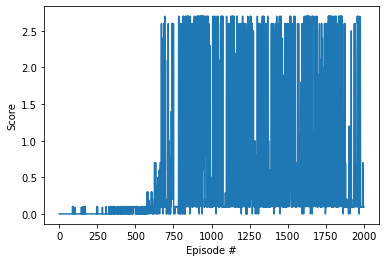

In [8]:
scores = ddpg(n_episodes=2000)

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

We can then use our trained agent to run through an iteration of the game to see how well it does and print out the winning score.

In [ ]:
env_info = env.reset(train_mode=False)[brain_name] # reset the environment
states = env_info.vector_observations               # get the current states
scores = np.zeros(num_agents)                       # initialize the scores
while True:
    actions = agent.act(states)                     # select ctions
    env_info = env.step(actions)[brain_name]        # send the actions to the environment
    next_states = env_info.vector_observations      # get the next states
    rewards = env_info.rewards                      # get the rewards
    dones = env_info.local_done                     # see if episode has finished
    scores += env_info.rewards                      # update the score
    states = next_states                            # roll over the states to next time step
    if np.any(dones):                               # exit loop if episode finished
        break
    
print("Score: {}".format(np.max(scores)))

When finished, you can close the environment.

In [ ]:
#env.close()